In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
# library import
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, StandardScaler, 
                                   MinMaxScaler, PowerTransformer, QuantileTransformer)
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings(action='ignore')

In [5]:
#데이터 불러오기

df=pd.read_csv('C:/Users/kshee/Desktop/방학스터디 데이터/insurance_dataset.csv')
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [6]:
df.tail()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
999995,59,male,46.67,2,no,northeast,High blood pressure,NaN,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,NaN,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728
999999,41,male,30.02,2,yes,northeast,Diabetes,Heart disease,Occasionally,Blue collar,Standard,23429.725030


In [7]:
#자료형, 결측치 측정
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [8]:
# 데이터의 평균과 표준편차, 최댓값, 최솟값, 사분위수

df.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


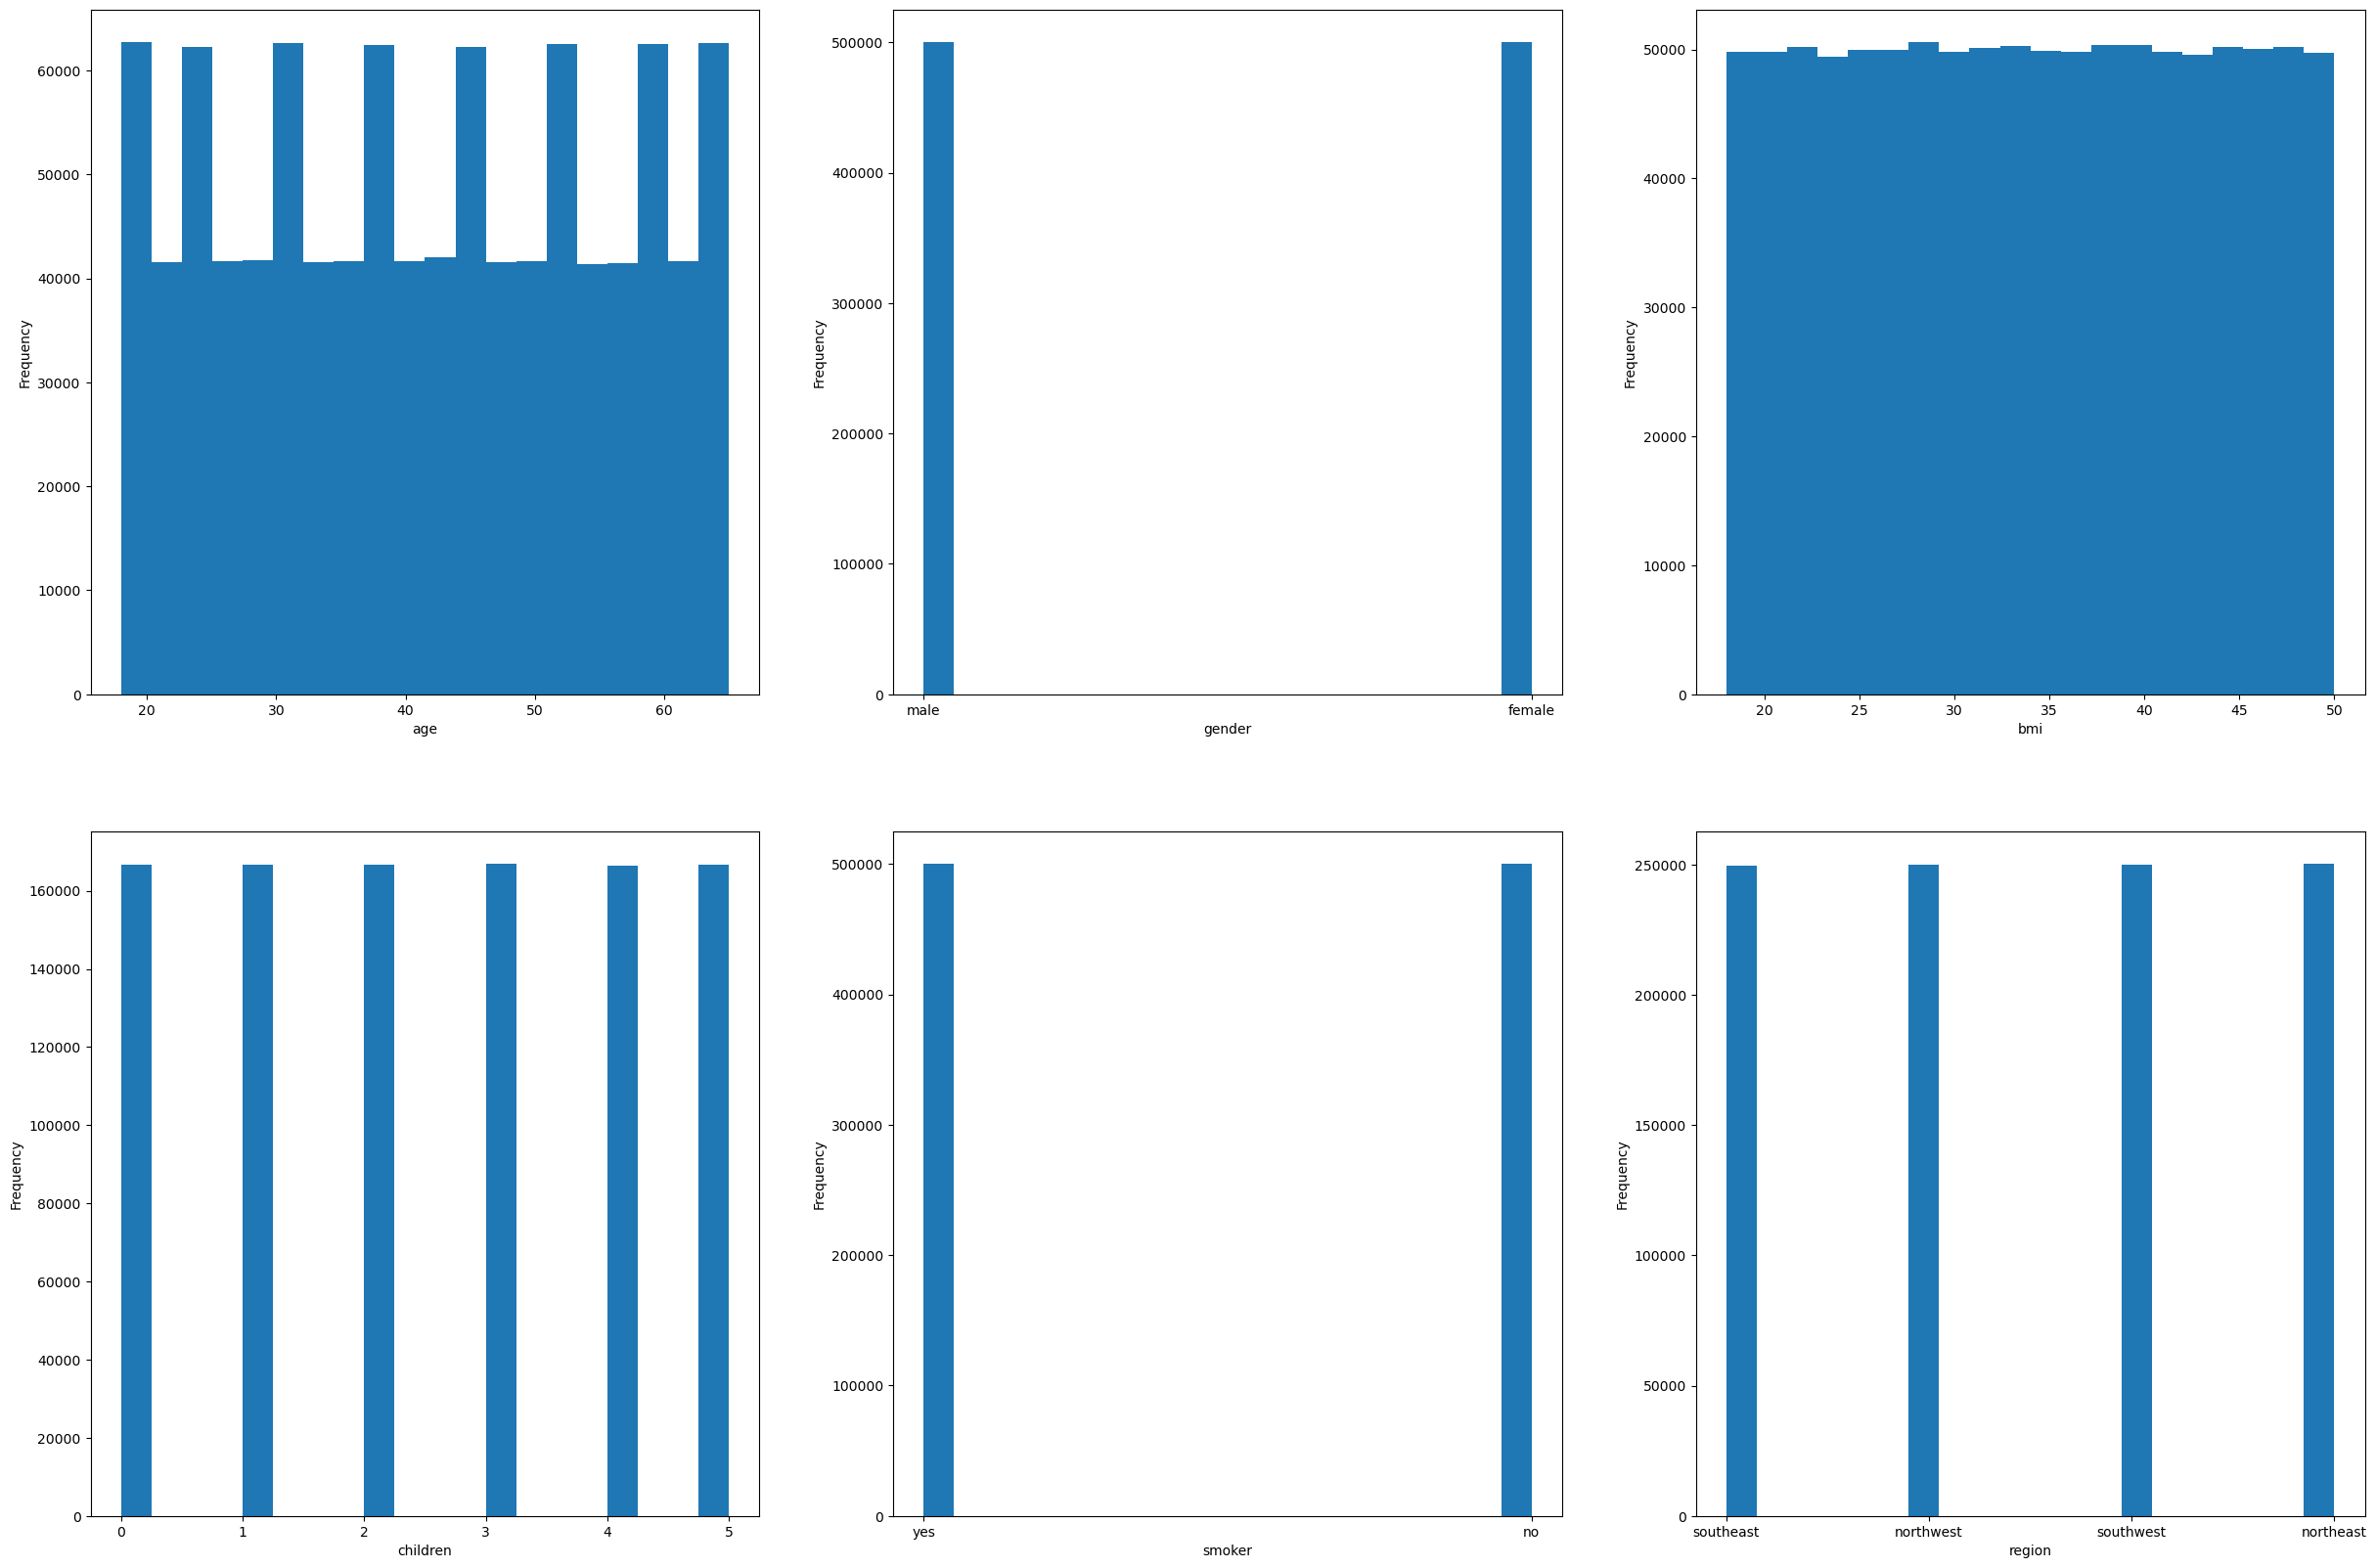

In [9]:
# 히스토그램을 통해 각 변수들의 분포를 살펴봅니다.
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

idx = 0 # 보험료를 제외한 feature들을 지정할 인덱스입니다.
for i in range(2): # subplot들의 행(row)
    for j in range(3): # subplot들의 열(column)
        colname = list(df.columns)[idx]
        ax[i][j].hist(df[colname], bins=20)
        ax[i][j].set_xlabel(colname)
        ax[i][j].set_ylabel('Frequency')
        
        idx += 1
        
plt.show()

In [10]:
#숫자형 상관관계

df[['age', 'bmi', 'children', 'charges']].corr()

,age,bmi,children,charges
age,1.000000,0.001428,-0.001317,0.063390
bmi,0.001428,1.000000,-0.001635,0.104429
children,-0.001317,-0.001635,1.000000,0.076801
charges,0.063390,0.104429,0.076801,1.000000


In [11]:
print(df['age'].min())
print(df['age'].max())

18
65


In [12]:
# 연령별 구간 설정- 시각화를 하기 위함(쩨거 ㄱ능)
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, np.inf]
age_bin = pd.cut(df['age'], bins=bins, labels=[i+1 for i in range(len(bins)-1)])
df['age_bin'] = age_bin
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges,age_bin
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669,7
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218,2
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302,5
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843,2
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838,7


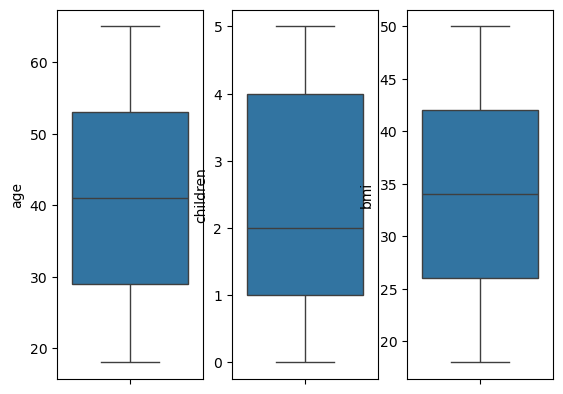

In [13]:
# 이상치 탐지를 위해 boxplot을 그려보겠습니다.
plt.subplot(1,3,1)
sns.boxplot(data=df, y='age')
plt.subplot(1,3,2)
sns.boxplot(data=df, y='children')
plt.subplot(1,3,3)
sns.boxplot(data=df, y='bmi')

plt.show()

In [14]:
# IQR(Q3 - Q1)로부터 이상치 파악하기
bmi_q1 = df['bmi'].quantile(q=0.25)
bmi_q3 = df['bmi'].quantile(q=0.75)
iqr = bmi_q3 - bmi_q1

# (q1 - (iqr * 1.5))와 (q3 + (iqr * 1.5))를 벗어난 값이 이상치입니다.
condi1 = (df['bmi'] < (bmi_q1 - (1.5 * iqr)))
condi2 = (df['bmi'] > (bmi_q3 + (1.5 * iqr)))
outliers = df[condi1 | condi2]
outliers['bmi']

Series([], Name: bmi, dtype: float64)

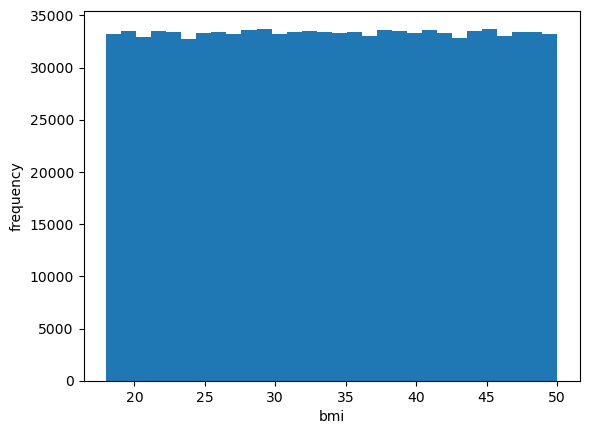

In [15]:
# bmi의 분포를 다시 한 번 그려봅니다.
plt.figsize = (10, 10)
plt.hist(df['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('frequency')
plt.show()